In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.optimize import linprog
import folium


sites_file = "Data-partie-1/Sites.csv"
onshore_file = "Data-partie-1/Rendements_onshore.csv"
offshore_file = "Data-partie-1/Rendements_offshore.csv"

P = 500000
k = 0.17

In [2]:
df = pd.read_csv(sites_file, skiprows=1, header=None)

data = df.values

onshore_capacity = np.array([i[7] for i in data if i[5] == "Non"], dtype=np.float64)
offshore_capacity = np.array([i[7] for i in data if i[5] == "Oui"], dtype=np.float64)
n_onshore = len(onshore_capacity)
n_offshore = len(offshore_capacity)
n = n_onshore+n_offshore

df_onshore = pd.read_csv(onshore_file, header=None)
df_offshore = pd.read_csv(offshore_file, header=None)

onshore_data = df_onshore.values
offshore_data = df_offshore.values

onshore_indices = np.where(data[:, 5] == "Non")[0]
offshore_indices = np.where(data[:, 5] == "Oui")[0]

onshore_yield = onshore_data[onshore_indices].astype(np.float64)
offshore_yield = offshore_data[offshore_indices].astype(np.float64)

In [3]:
T = np.shape(onshore_yield)[1]
C = np.concatenate((onshore_capacity, offshore_capacity))
Y = np.concatenate((onshore_yield, offshore_yield))
E = C[:, np.newaxis] * Y

In [4]:
obj_func_coeffs = np.concatenate((np.zeros(n), [-1]))

i_matrix = np.concatenate((
    np.hstack((np.concatenate((np.identity(n), -np.identity(n))), np.zeros((2 * n, 1)))),
    np.hstack((-np.transpose(E), np.ones((T, 1))))
))
i_vector = np.concatenate((
    np.ones(n),
    np.zeros(n + T)
))

e_matrix = np.array([
    np.concatenate((C, [0])),
    np.concatenate((np.zeros(n_onshore), offshore_capacity, [0]))
])
e_vector = np.array([P, k * P])

solution = linprog(c=obj_func_coeffs, A_ub=i_matrix, b_ub=i_vector, A_eq=e_matrix, b_eq=e_vector)

print(len(i_vector),n,T)

S = solution.x[:n]
M = -solution.fun

10044 642 8760


In [5]:
E_produced = np.zeros(T)
Yield = np.zeros(T)

for j in range(T):
    E_produced[j] = np.dot(S, E[:, j])
    Yield[j] = np.dot(S, Y[:, j]) / np.sum(S)

E_total = np.sum(E_produced)
Yield_avg = np.mean(Yield)


In [6]:
latitude = [i[1] for i in data]
longitude = [i[2] for i in data]
country = [i[3] for i in data]
color = [i[4] for i in data]

latitude = pd.to_numeric(latitude, errors='coerce')
longitude = pd.to_numeric(longitude, errors='coerce')

valid_indices = np.where(~np.isnan(latitude) & ~np.isnan(longitude))
latitude = latitude[valid_indices]
longitude = longitude[valid_indices]
color = np.array(color)[valid_indices]

In [7]:
m = folium.Map(location=[np.median(latitude), np.median(longitude)], zoom_start=3)

print(S)

size = 4
# Add points to the map
for idx in range(len(latitude)):
    if S[idx] == 0:
        continue
    folium.CircleMarker(
        location=[latitude[idx], longitude[idx]],
        radius=size * S[idx], 
        color=color[idx],
        fill=True,
        fill_color=color[idx],
        fill_opacity=1.0 
    ).add_to(m)

m.save(outfile="map.html")
display(m)

[1.         1.         1.         0.         1.         0.
 0.19534158 1.         1.         1.         0.         0.
 0.         1.         1.         1.         1.         0.
 0.         0.         1.         1.         1.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 1.         1.         0.         0.         0.         1.
 1.         1.         0.         0.         0.         0.
 0.11680891 1.         0.         0.         0.         0.
 1.         1.         1.         1.         1.         1.
 1.         0.11498911 1.         1.         0.         1.
 1.         1.         1.         1.         0.         0.
 0.         0.         1.         1.         1.         1.
 1.         0.         0.         1.         0.82680332 0.
 0.         0.         0.         0.         0.         

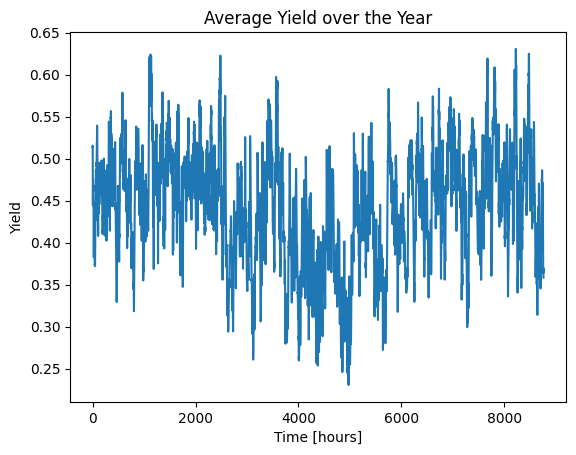

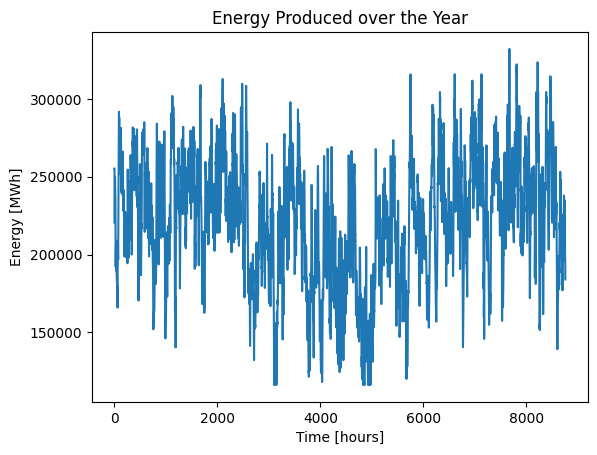

In [8]:
plt.plot(Yield)
plt.xlabel('Time [hours]')
plt.ylabel('Yield')
plt.title('Average Yield over the Year')
plt.savefig('average_yield.png')
plt.show()


plt.plot(E_produced)
plt.xlabel('Time [hours]')
plt.ylabel('Energy [MWh]')
plt.title('Energy Produced over the Year')
plt.savefig('energy_produced.png')
plt.show()

In [9]:
windmills_used = sum(S)

print(f"Minimum energy produced in one hour: {M}")
print(f"Average annual yield: {Yield_avg*100}%")
print(f"Energy produced in one year: {E_total}")
print(f"Amount of windmills used: {windmills_used}")

Minimum energy produced in one hour: 116226.59223094779
Average annual yield: 44.166513759219114%
Energy produced in one year: 1945870075.4489331
Amount of windmills used: 266.95540938960335


#Q2

In [10]:
T = np.shape(onshore_yield)[1]
C = np.concatenate((onshore_capacity, offshore_capacity))
Y = np.concatenate((onshore_yield, offshore_yield))
E = C[:, np.newaxis] * Y
percentage_bought = 0.1


In [11]:
def solver2(percentage_bought):
    A_max = P*percentage_bought*T
    A = np.zeros(T)


    obj_func_coeffs = np.concatenate((np.zeros(n+T), [-1]))

    i_matrix = np.concatenate((
        np.hstack((np.concatenate((np.identity(n), -np.identity(n))), np.zeros((2 * n, T+1)))),
        np.hstack((-np.transpose(E), -np.identity(T),np.ones((T, 1)))),
        np.hstack((np.zeros((T,n)),-np.identity(T),np.zeros((T,1)))),
        np.hstack((np.zeros((1,n)),np.ones((1,T)),np.zeros((1,1))))
    ))
    i_vector = np.concatenate((
        np.ones(n),
        np.zeros(shape=n),
        np.zeros(2*T),
        [A_max]
    ))

    e_matrix = np.array([
        np.concatenate((C, np.zeros(T),[0])),
        np.concatenate((np.zeros(n_onshore), offshore_capacity,np.zeros(T+1)))
    ])
    e_vector = np.array([P, k * P])


    solution = linprog(c=obj_func_coeffs, A_ub=i_matrix, b_ub=i_vector, A_eq=e_matrix, b_eq=e_vector)

    S = solution.x[:n]
    A = solution.x[n:-1]
    M = -solution.fun
    print(M,sum(A))
    return S,A,M

percentage_bought = 0.1
S,A,M = solver2(percentage_bought)

291175.0614412198 438000000.00000036


In [12]:
E_produced = np.zeros(T)
Yield = np.zeros(T)

for j in range(T):
    E_produced[j] = np.dot(S, E[:, j])
    Yield[j] = np.dot(S, Y[:, j]) / np.sum(S)

E_total = np.sum(E_produced)
Yield_avg = np.mean(Yield)

In [13]:
latitude = [i[1] for i in data]
longitude = [i[2] for i in data]
country = [i[3] for i in data]
color = [i[4] for i in data]

latitude = pd.to_numeric(latitude, errors='coerce')
longitude = pd.to_numeric(longitude, errors='coerce')

valid_indices = np.where(~np.isnan(latitude) & ~np.isnan(longitude))
latitude = latitude[valid_indices]
longitude = longitude[valid_indices]
color = np.array(color)[valid_indices]

In [14]:
m = folium.Map(location=[np.median(latitude), np.median(longitude)], zoom_start=3)

print(S)

size = 4
# Add points to the map
for idx in range(len(latitude)):
    if S[idx] == 0:
        continue
    folium.CircleMarker(
        location=[latitude[idx], longitude[idx]],
        radius=size * S[idx], 
        color=color[idx],
        fill=True,
        fill_color=color[idx],
        fill_opacity=1.0 
    ).add_to(m)

m.save(outfile="map_Q2.html")
display(m)

[1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         0.
 0.         0.         0.         1.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 1.         1.         1.         0.         0.         0.
 1.         1.         0.         0.         0.         0.
 0.         1.         1.         0.         1.         1.
 1.         1.         1.         1.         0.         0.
 1.         1.         1.         1.         0.         1.
 1.         1.         1.         1.         0.         0.
 1.         0.         1.         1.         1.         1.
 1.         1.         0.         1.         1.         0.
 1.         0.         0.         0.         0.         

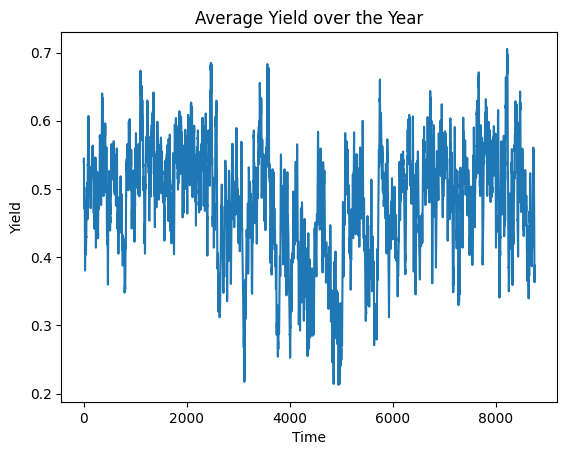

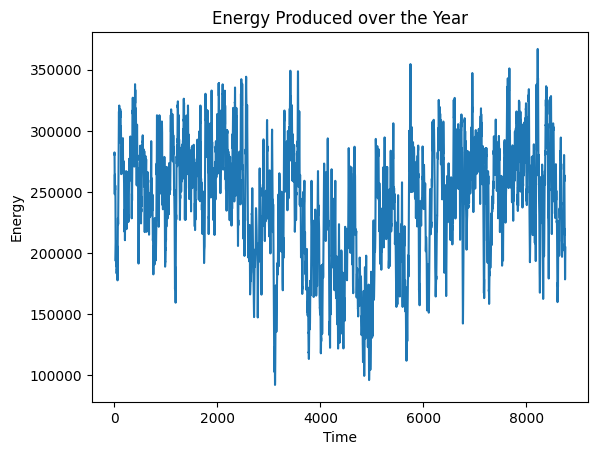

In [15]:
plt.plot(Yield)
plt.xlabel('Time')
plt.ylabel('Yield')
plt.title('Average Yield over the Year')
plt.savefig('average_yield_Q2.png')
plt.show()


plt.plot(E_produced)
plt.xlabel('Time')
plt.ylabel('Energy')
plt.title('Energy Produced over the Year')
plt.savefig('energy_produced_Q2.png')
plt.show()

In [16]:
print("Energy bought: ", sum(A))

print(f"Minimum energy in one hour: {M}")
print(f"Average annual yield: {Yield_avg*100}%")
print(f"Energy produced in one year: {E_total}")
print(f"Amount of windmills used: {windmills_used}")

Energy bought:  438000000.00000036
Minimum energy in one hour: 291175.0614412198
Average annual yield: 48.26802443550064%
Energy produced in one year: 2137532402.4496198
Amount of windmills used: 266.95540938960335


energy bought:  437999999.9999995
270.68847073449456
291175.0614412198


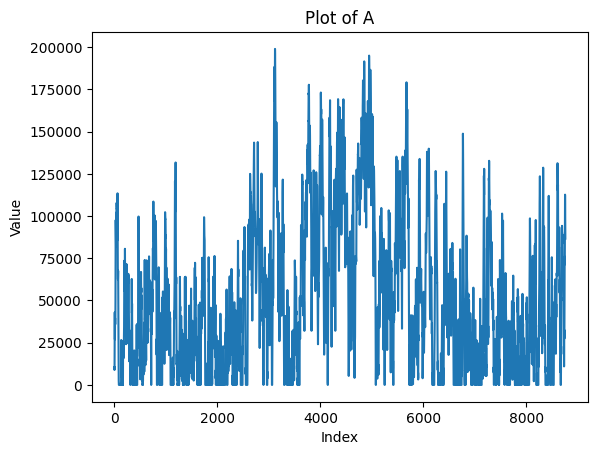

In [17]:
import matplotlib.pyplot as plt
import numpy as np
print("energy bought: ",np.sum(A))
print(np.sum(S))
print(M)
# Assuming A is a numpy array
plt.plot(np.arange(len(A)), A)
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Plot of A')
plt.show()


In [3]:
# percentage_bought = 0.1


E_list = np.zeros(20)
for i in range(0,21):
    percentage_bought = i/20
    S,A,M = solver2(percentage_bought)
    E_list[i] = M
print(E_list)

0.0
0.05
0.1
0.15
0.2
0.25
0.3
0.35
0.4
0.45
0.5
0.55
0.6
0.65
0.7
0.75
0.8
0.85
0.9
0.95
1.0


NameError: name 'E_list' is not defined

In [ ]:
plt.plot(E_list)
plt.title('Values in E_list')
plt.xlabel('Index')
plt.ylabel('Value')
plt.show()

#Q3

In [ ]:
T = np.shape(onshore_yield)[1]
C = np.concatenate((onshore_capacity, offshore_capacity))
Y = np.concatenate((onshore_yield, offshore_yield))
E = C[:, np.newaxis] * Y
Var = np.zeros(T)

In [ ]:

obj_func_coeffs = np.concatenate((np.zeros(n+T), [-1]))

i_matrix = np.concatenate((
    np.hstack((np.concatenate((np.identity(n), -np.identity(n))), np.zeros((2 * n, T+1)))),
    np.hstack((-np.transpose(E), -np.identity(T),np.ones((T, 1)))),
    np.hstack((np.zeros((T,n)),-np.identity(T),np.zeros((T,1)))),
    np.hstack((np.zeros((1,n)),np.ones((1,T)),np.zeros((1,1))))
))
i_vector = np.concatenate((
    np.ones(n),
    np.zeros(shape=n),
    np.zeros(2*T),
    [A_max]
))

e_matrix = np.array([
    np.concatenate((C, np.zeros(T),[0])),
    np.concatenate((np.zeros(n_onshore), offshore_capacity,np.zeros(T+1)))
])
e_vector = np.array([P, k * P])


solution = linprog(c=obj_func_coeffs, A_ub=i_matrix, b_ub=i_vector, A_eq=e_matrix, b_eq=e_vector)

S = solution.x[:n]
A = solution.x[n:-1]
M = -solution.fun
print(M,sum(A))